In [260]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
import seaborn as sns
from IPython.display import clear_output


import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
 
import seedlingTools as st

In [261]:
imageDirectory = "/media/jee/Shared Partition/camera/pre-move/day"
imageList = st.get_image_list(imageDirectory)

Searching in : /media/jee/Shared Partition/camera/pre-move/day
Found 160 .jpg images.


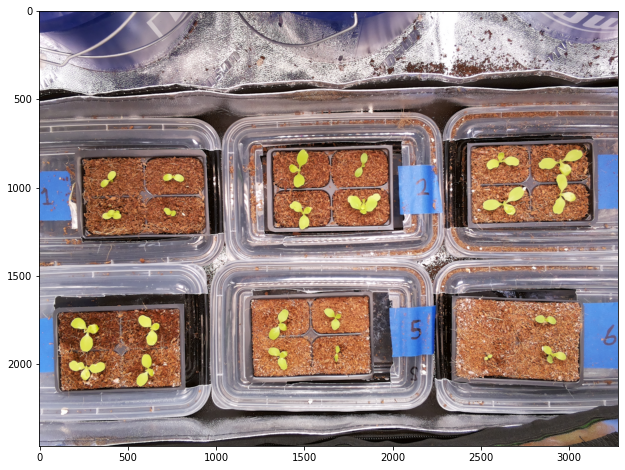

In [262]:
# Show an image form imageList
st.show_image_file(imageList[159])

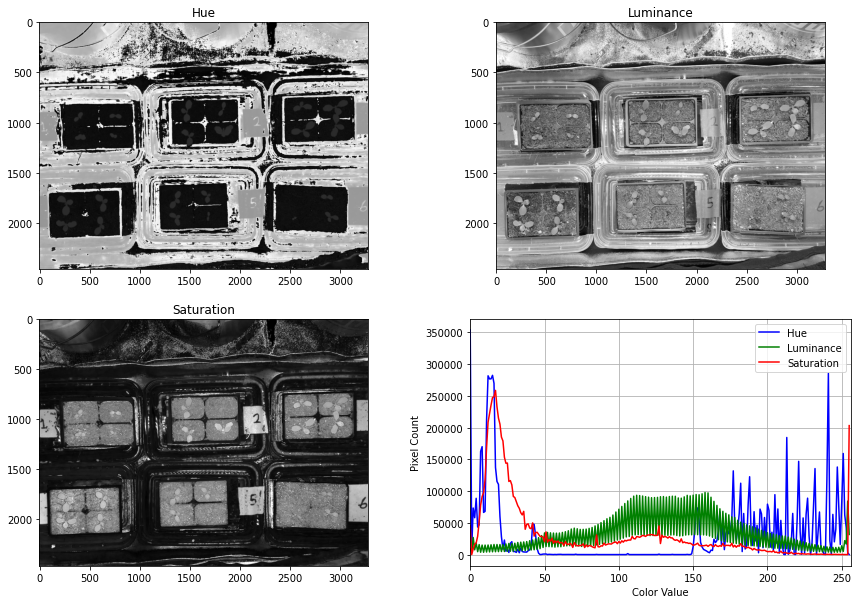

In [264]:
st.plot_image_file_histogram_hls(imageList[159])

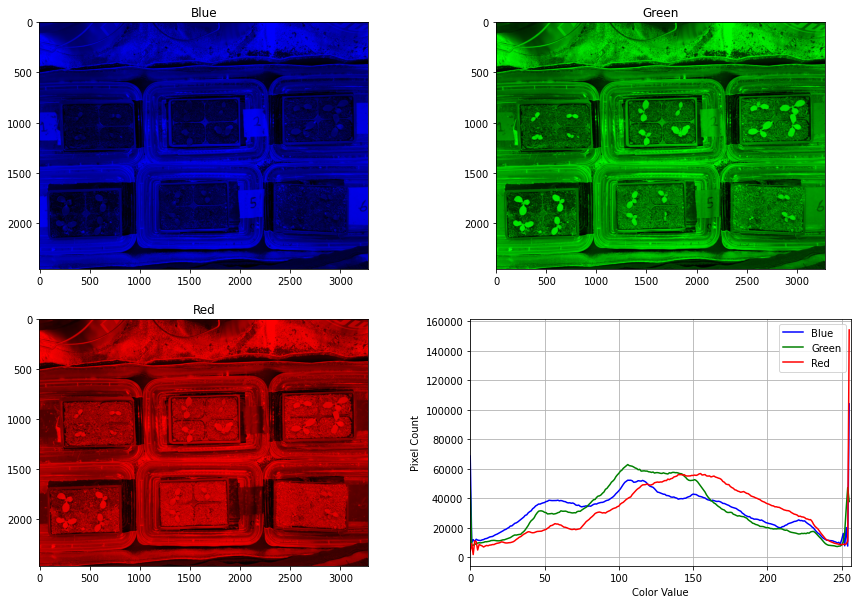

In [265]:
st.plot_image_file_histogram_bgr(imageList[159])

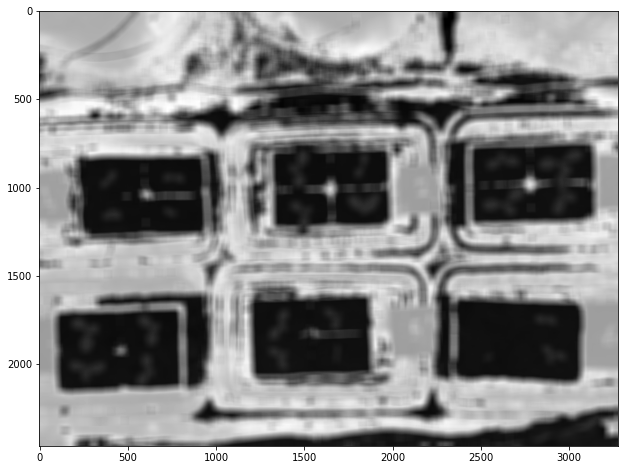

In [266]:
img = cv2.imread(imageList[159])
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
imgHue = imgHLS[:,:,0]
imgHueBlurred = cv2.blur(imgHue, (50,50))
st.show_image(imgHueBlurred, cmap='gray')

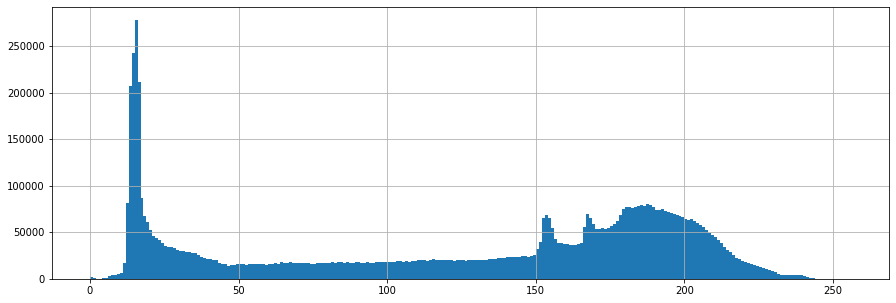

In [267]:
st.plot_gray_histogram(imgHueBlurred)

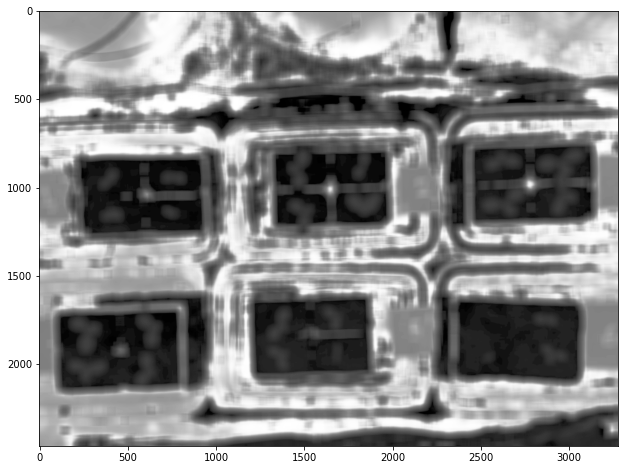

In [268]:
equ = cv2.equalizeHist(imgHueBlurred)
st.show_image(equ, cmap='gray')

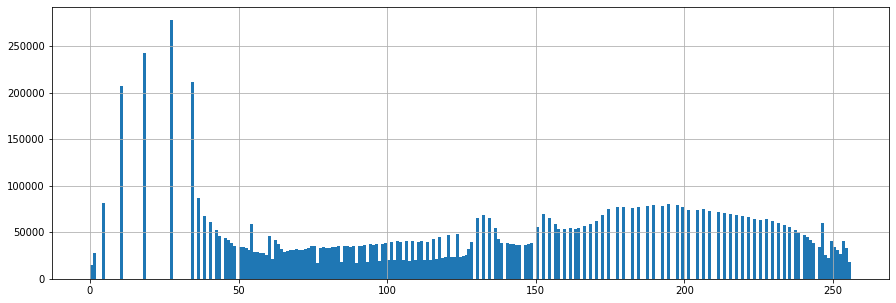

In [269]:
st.plot_gray_histogram(equ)

128.5351663961039


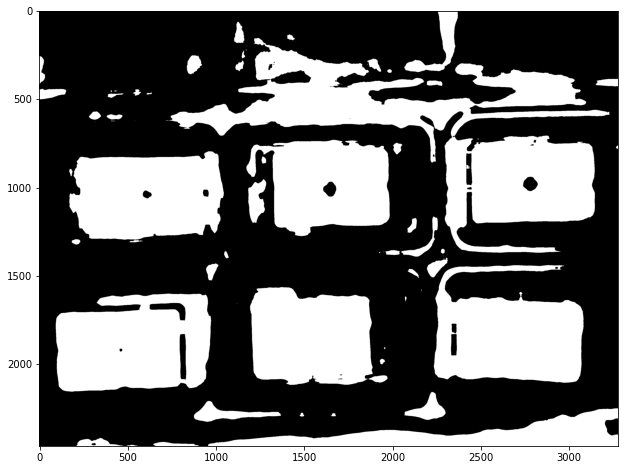

In [270]:
mean = np.mean(equ)
print(mean)
ret, thresh1 = cv2.threshold(equ, 0.75*mean, 255, cv2.THRESH_BINARY_INV)
st.show_image(thresh1, cmap='gray')

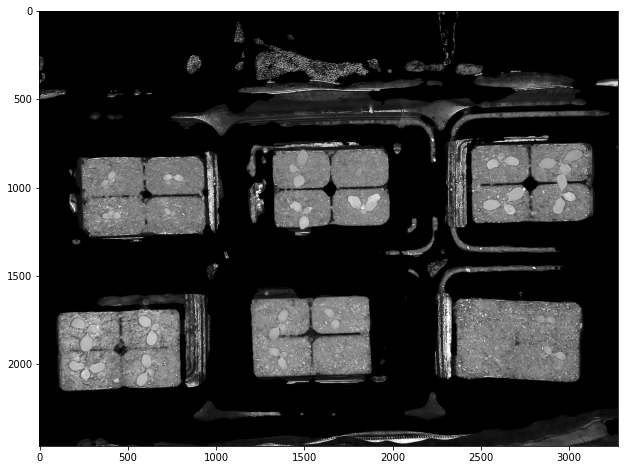

In [271]:
maskedSaturation = np.bitwise_and(imgHLS[:,:,2], thresh1)
st.show_image(maskedSaturation, cmap='gray')

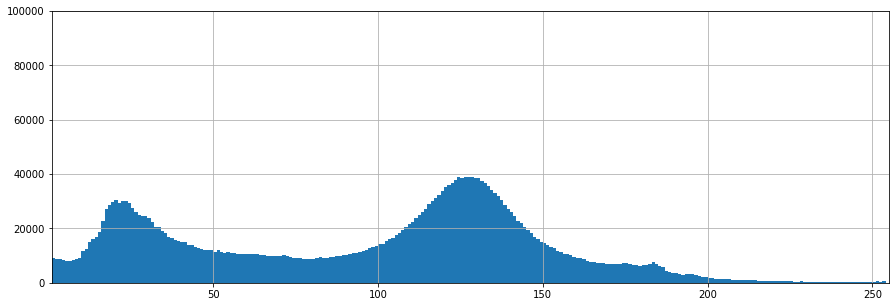

In [272]:
maskedSaturationBlurred = cv2.blur(maskedSaturation, (5,5))

plt.figure(figsize=(15,5))
plt.hist(maskedSaturationBlurred.ravel(),256,[0,256])
plt.xlim(1,255)
plt.ylim(0, 100000)
plt.grid()

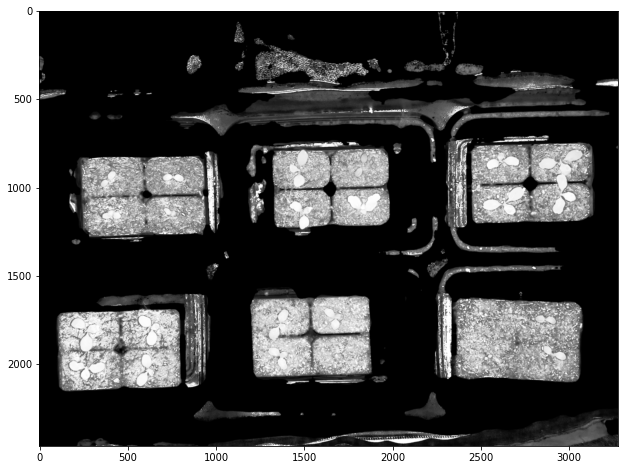

In [273]:
equSaturation = cv2.equalizeHist(maskedSaturationBlurred)
st.show_image(equSaturation, cmap='gray')

50.1173943815331


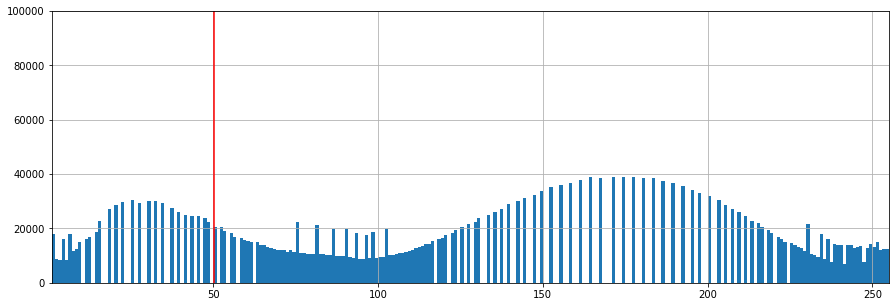

In [274]:
meanSaturation = np.mean(equSaturation)
print(meanSaturation)
plt.figure(figsize=(15,5))
plt.hist(equSaturation.ravel(),256,[0,256])
plt.axvline(meanSaturation, color='red')
plt.xlim(1,255)
plt.ylim(0, 100000)
plt.grid()

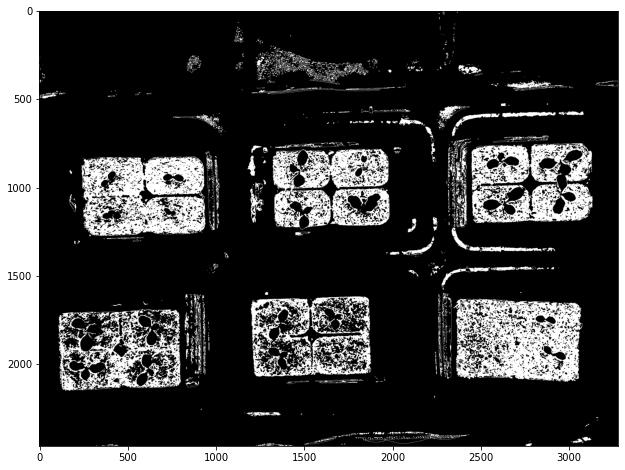

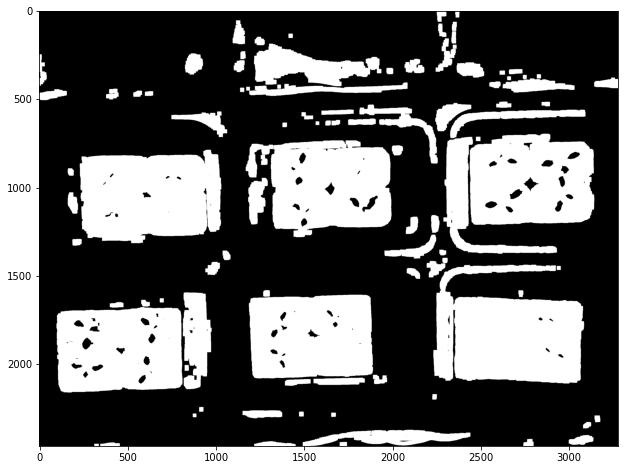

In [275]:
ret, threshSaturation = cv2.threshold(equSaturation, meanSaturation*2, 255, cv2.THRESH_TOZERO)
ret, threshSaturation = cv2.threshold(threshSaturation, 200, 255, cv2.THRESH_TOZERO_INV)
ret, threshSaturation = cv2.threshold(threshSaturation, 1, 255, cv2.THRESH_BINARY)
kernel = np.ones((3,3), dtype=np.uint8)
dilated = cv2.dilate(threshSaturation,kernel,iterations = 10)
st.show_image(threshSaturation, cmap='gray')
st.show_image(dilated, cmap='gray')

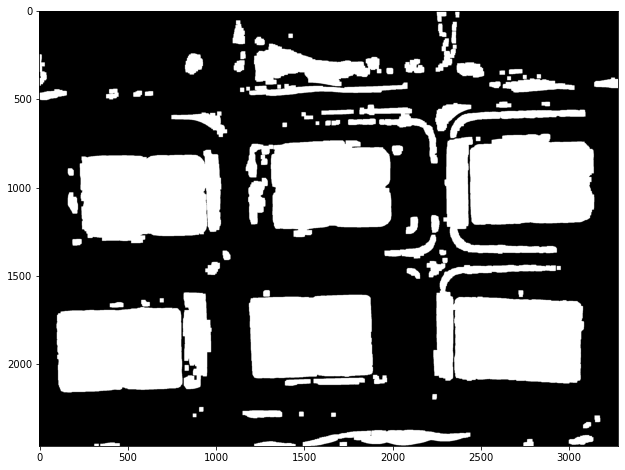

In [276]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
externalContours = np.zeros(dilated.shape)
for i in range(len(contours)):
    # external contours
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(externalContours, contours, i, 255, -1)
st.show_image(externalContours, cmap='gray')

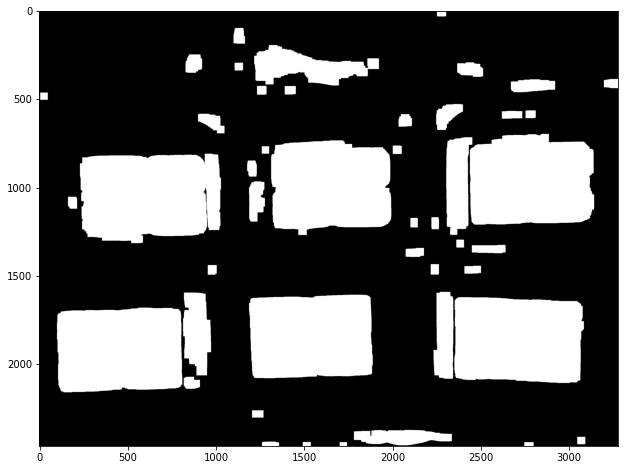

In [277]:
kernel = np.ones((3,3), dtype=np.uint8)
opening = cv2.morphologyEx(externalContours, cv2.MORPH_OPEN, kernel, iterations=20)
st.show_image(opening, cmap='gray')

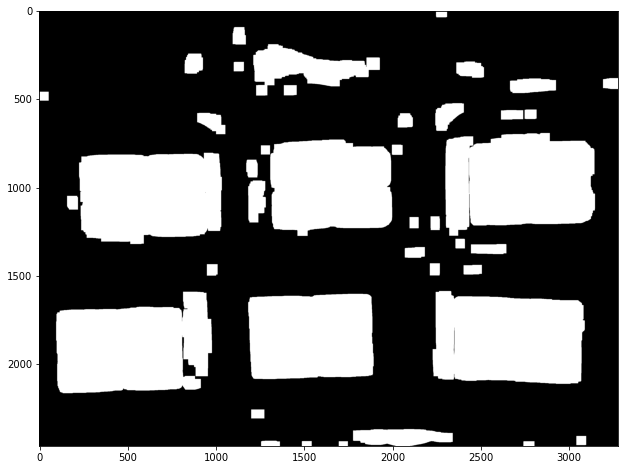

255.0


In [278]:
dilation = cv2.dilate(opening,kernel,iterations = 5)
st.show_image(dilation, cmap='gray')
print(np.max(dilation))

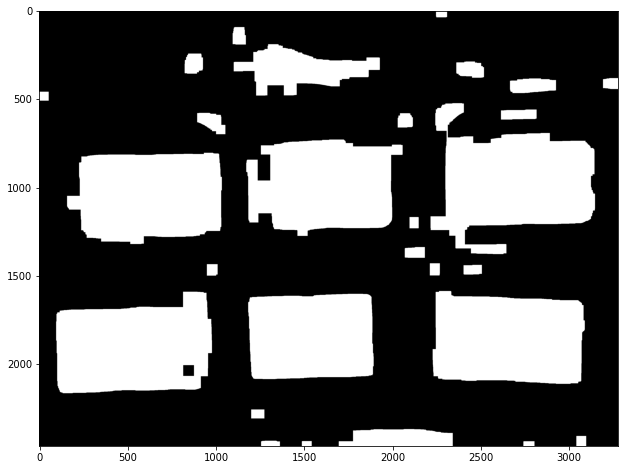

In [279]:
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel, iterations=30)
st.show_image(closing, cmap='gray')

In [280]:
hueDistanceTransform = cv2.distanceTransform(closing.astype(np.uint8), cv2.DIST_L2, 5)

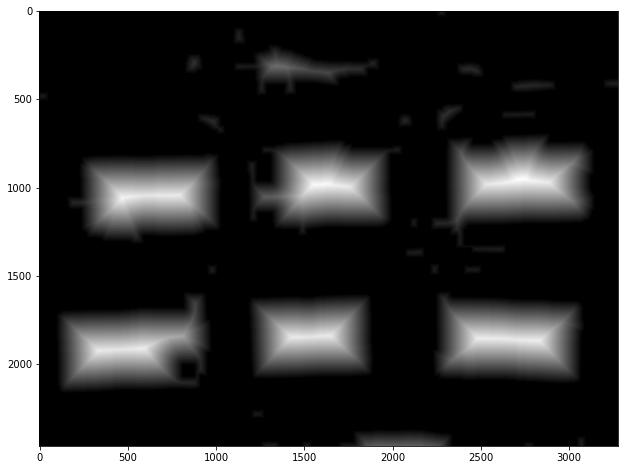

In [281]:
st.show_image(hueDistanceTransform, cmap='gray')

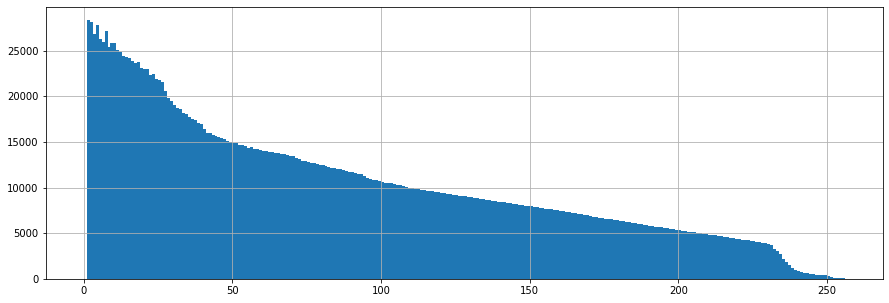

In [282]:
st.plot_gray_histogram(hueDistanceTransform[hueDistanceTransform!=0])

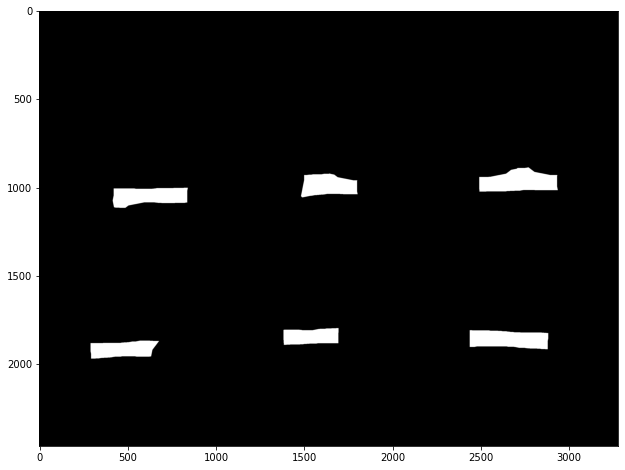

In [283]:
0.75*np.max(hueDistanceTransform)
ret, distanceThresh = cv2.threshold(hueDistanceTransform, 0.75*np.max(hueDistanceTransform), 255, cv2.THRESH_BINARY)
st.show_image(distanceThresh, cmap='gray')

In [284]:
def timing_printer(text, start, timingList):
    elapsed = time.time()-start
    if len(timingList)!=0:
        elapsed = elapsed - timingList[-1][1]
    print(text + ": {} seconds".format(round(elapsed, 3)))
    return (text, elapsed)

def separate_seed_trays_step1(file, timing = False):
    timingList = []
    start = time.time()
    img = cv2.imread(file)
    if timing: timingList.append(timing_printer("Read Image", start, timingList))
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
    if timing: timingList.append(timing_printer("Convert to HLS", start, timingList))
    imgHue = imgHLS[:,:,0]
    imgHueBlurred = cv2.blur(imgHue, (50,50))
    if timing: timingList.append(timing_printer("Blur Image", start, timingList))
    equ = cv2.equalizeHist(imgHueBlurred)
    if timing: timingList.append(timing_printer("Equalize Hue Histogram", start, timingList))
    mean = np.mean(equ)
    ret, thresh1 = cv2.threshold(equ, 0.75*mean, 255, cv2.THRESH_BINARY_INV)
    if timing: timingList.append(timing_printer("Create Mask for Saturation", start, timingList))
    maskedSaturation = np.bitwise_and(imgHLS[:,:,2], thresh1)
    maskedSaturationBlurred = cv2.blur(maskedSaturation, (5,5))
    equSaturation = cv2.equalizeHist(maskedSaturationBlurred)
    meanSaturation = np.mean(equSaturation)
    ret, threshSaturation = cv2.threshold(equSaturation, meanSaturation*2, 255, cv2.THRESH_TOZERO)
    ret, threshSaturation = cv2.threshold(threshSaturation, 200, 255, cv2.THRESH_TOZERO_INV)
    ret, threshSaturation = cv2.threshold(threshSaturation, 1, 255, cv2.THRESH_BINARY)
    if timing: timingList.append(timing_printer("Threshold Saturation", start, timingList))
    kernel = np.ones((3,3), dtype=np.uint8)
    dilated = cv2.dilate(threshSaturation,kernel,iterations = 10)
    if timing: timingList.append(timing_printer("Dilate Saturation", start, timingList))
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    externalContours = np.zeros(dilated.shape)
    for i in range(len(contours)):
        # external contours
        if hierarchy[0][i][3] == -1:
            cv2.drawContours(externalContours, contours, i, 255, -1)
    if timing: timingList.append(timing_printer("Analyze Contours", start, timingList))
    kernel = np.ones((3,3), dtype=np.uint8)
    opening = cv2.morphologyEx(externalContours, cv2.MORPH_OPEN, kernel, iterations=20)
    if timing: timingList.append(timing_printer("Morphological Opening", start, timingList))
    dilation = cv2.dilate(opening,kernel,iterations = 5)
    if timing: timingList.append(timing_printer("Morphological Dilation", start, timingList))
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel, iterations=30)
    if timing: timingList.append(timing_printer("Morphological Closing", start, timingList))
    hueDistanceTransform = cv2.distanceTransform(closing.astype(np.uint8), cv2.DIST_L2, 5)
    ret, distanceThresh = cv2.threshold(hueDistanceTransform, 0.75*np.max(hueDistanceTransform), 255, cv2.THRESH_BINARY)
    if timing: timingList.append(timing_printer("Distance Transform Analysis", start, timingList))
    if timing:
        return distanceThresh, timingList
    else:
        return distanceThresh


In [288]:
start = time.time()
for i, file in enumerate(imageList):
    elapsed = time.time() - start
    print("Processed Image: {}/{}. Time Elapsed: {}".format(i+1, len(imageList), round(elapsed,1)), end='\r')
    threshImage = separate_seed_trays_step1(file)
    threshFile = "seed-tray-step1".join(file.split('day'))
    cv2.imwrite(threshFile, threshImage)

In [289]:
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/seed-tray-step1/", frameRate=10)

In [290]:
threshImage, timingList = separate_seed_trays_step1(file, timing=True)


Read Image: 0.144 seconds
Convert to HLS: 0.006 seconds
Blur Image: 0.156 seconds
Equalize Hue Histogram: 0.008 seconds
Create Mask for Saturation: 0.162 seconds
Threshold Saturation: 0.028 seconds
Dilate Saturation: 0.166 seconds
Analyze Contours: 0.043 seconds
Morphological Opening: 0.55 seconds
Morphological Dilation: 0.092 seconds
Morphological Closing: 1.155 seconds
Distance Transform Analysis: 0.13 seconds


In [291]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di
      
# Driver Code    
dictionary = {}
di = Convert(timingList, dictionary)

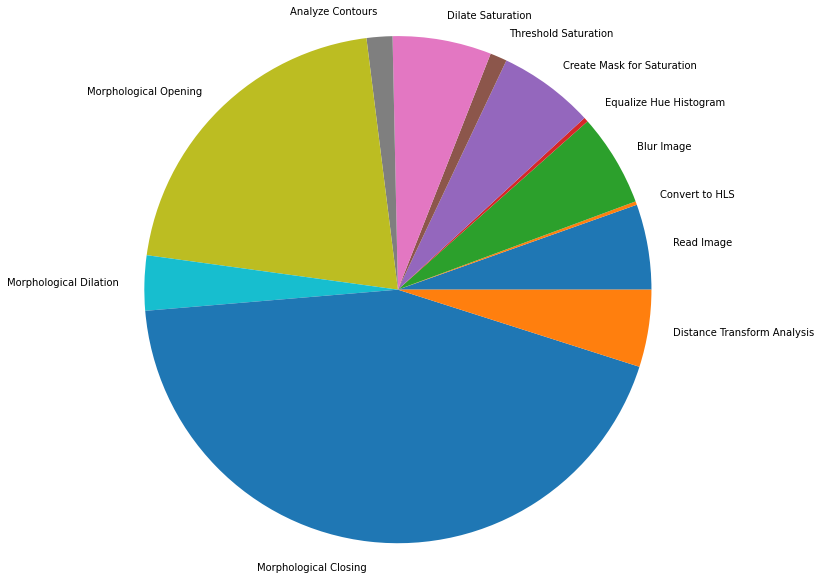

In [292]:
# Data to plot
labels = []
sizes = []

for x, y in di.items():
    labels.append(x)
    sizes.append(y[0])
# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

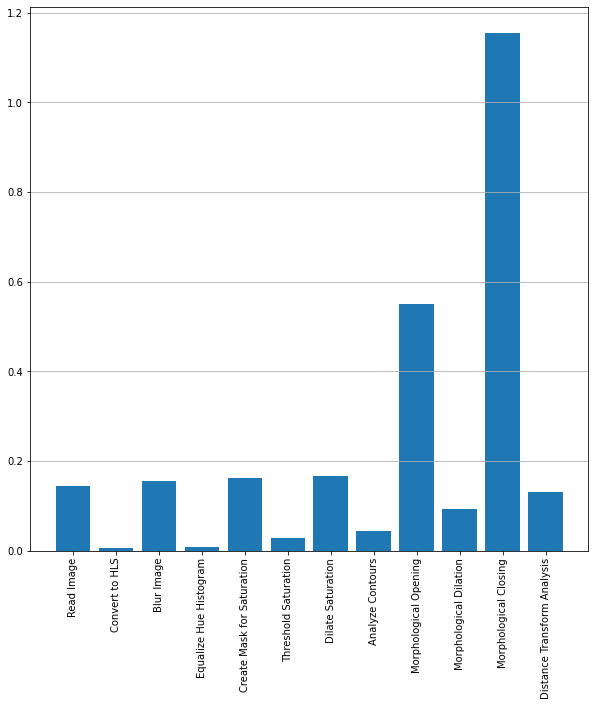

In [293]:
# Data to plot
labels = []
sizes = []
for x, y in di.items():
    labels.append(x)
    sizes.append(y[0])
# Plot
plt.figure(figsize=(10,10))
# plt.pie(sizes, labels=labels)
plt.bar(labels, sizes)
plt.gca().yaxis.grid(True)
plt.xticks(rotation='vertical')
plt.show()

# Find the middle of the trays

Searching in : /media/jee/Shared Partition/camera/pre-move/seed-tray-step1/
Found 160 .jpg images.


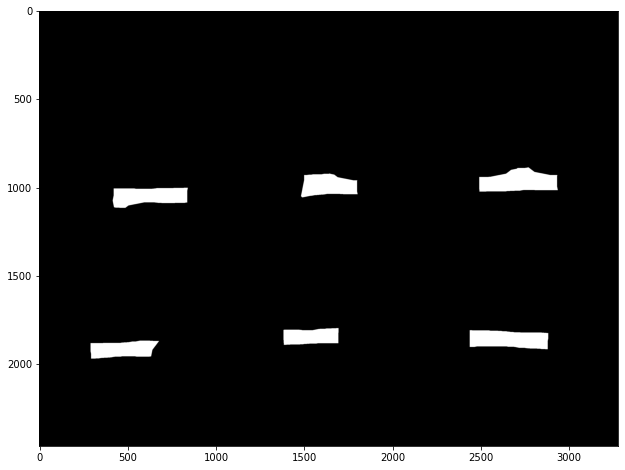

In [294]:
imageDirectory = "/media/jee/Shared Partition/camera/pre-move/seed-tray-step1/"
imageList = st.get_image_list(imageDirectory)
imageTray = cv2.imread(imageList[159],0)
st.show_image(imageTray, cmap='gray')

In [295]:
# noise removal
kernel = np.ones((3,3),np.uint8)

# sure background area
sure_bg = externalContours.copy()

sure_fg = imageTray.copy()

sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg,sure_fg)

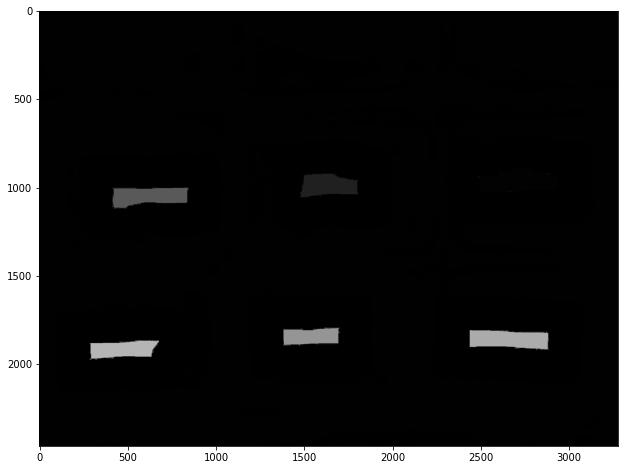

In [296]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

st.show_image(markers, cmap='gray')

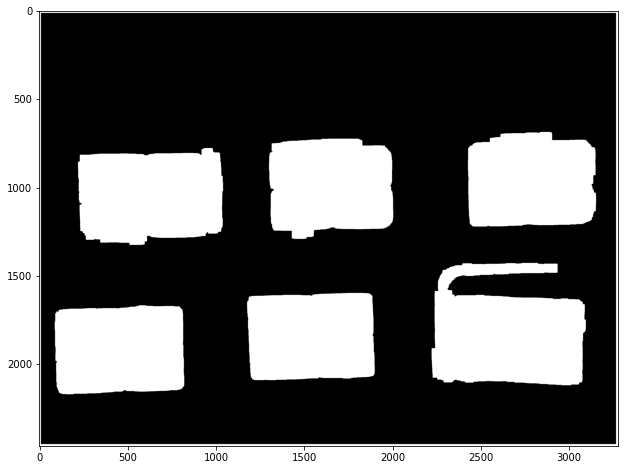

In [297]:
imageHueThreeChannel = cv2.cvtColor(np.uint8(externalContours), cv2.COLOR_GRAY2BGR)
imageWatershed = cv2.watershed(imageHueThreeChannel,markers)
ret, threshFinal = cv2.threshold(np.uint8(imageWatershed), 1, 255, cv2.THRESH_BINARY)
dilatedFinal = cv2.dilate(threshFinal,kernel,iterations = 10)

st.show_image(dilatedFinal, cmap="gray")

In [298]:
xCollapsed = np.mean(imageTray, axis=1)
yDivider = np.mean(np.where(xCollapsed!=0))

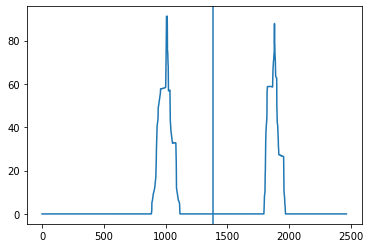

In [299]:
plt.plot(xCollapsed)
plt.axvline(yDivider)

In [300]:
np.mean(np.where(xCollapsed!=0))

1383.122641509434

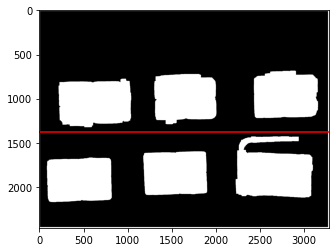

In [301]:
plt.imshow(dilatedFinal, cmap='gray')
plt.axhline(yDivider, color='red')

In [302]:
imageTrayTop = imageTray[0:int(yDivider), :]
yCollapsedTop = np.mean(imageTrayTop, axis=0)

In [303]:
def find_x_critical_points(collapsedList, verbose=False):
    criticalPoints = [0]*6
    for i in range(len(collapsedList)):
        if collapsedList[i] > 0 and criticalPoints[0]==0:
            criticalPoints[0] = i
            if verbose: print(criticalPoints[0])
        if criticalPoints[0]!=0 and collapsedList[i] == 0 and criticalPoints[1]==0:
            criticalPoints[1] = i
            if verbose: print(criticalPoints[1])
        if criticalPoints[1]!=0 and collapsedList[i] != 0 and criticalPoints[2]==0:
            criticalPoints[2] = i
            if verbose: print(criticalPoints[2])
        if criticalPoints[2]!=0 and collapsedList[i] == 0 and criticalPoints[3]==0:
            criticalPoints[3] = i
            if verbose: print(criticalPoints[3])
        if criticalPoints[3]!=0 and collapsedList[i] != 0 and criticalPoints[4]==0:
            criticalPoints[4] = i
            if verbose: print(criticalPoints[4])
        if criticalPoints[4]!=0 and collapsedList[i] == 0 and criticalPoints[5]==0:
            criticalPoints[5] = i
            if verbose: print(criticalPoints[5])
    x1 = np.mean([criticalPoints[1], criticalPoints[2]])
    x2 = np.mean([criticalPoints[3], criticalPoints[4]])
    return criticalPoints, x1, x2

criticalPoints, x1Top, x2Top = find_x_critical_points(yCollapsedTop)

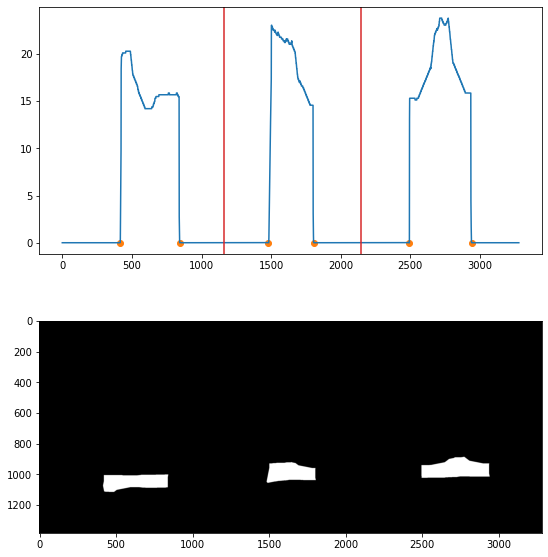

In [304]:
fig, ax = plt.subplots(2, figsize=(9,10))
ax[0].plot(yCollapsedTop)
ax[0].scatter(criticalPoints, [0]*len(criticalPoints), color='#ff7f0e')
ax[0].axvline(x1Top, color = "#d62728")
ax[0].axvline(x2Top, color = "#d62728")
ax[1].imshow(imageTrayTop, cmap='gray')

In [305]:
imageTrayBottom = imageTray[int(yDivider):, :]
criticalPoints, x1Bottom, x2Bottom = find_x_critical_points(yCollapsedBottom)

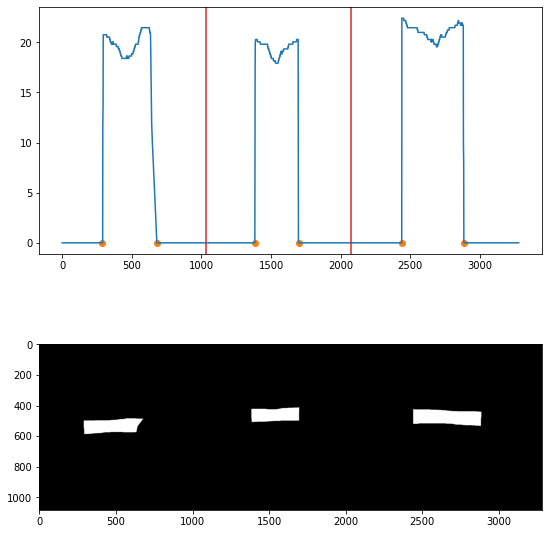

In [306]:
fig, ax = plt.subplots(2, figsize=(9,10))
ax[0].plot(yCollapsedBottom)
ax[0].scatter(criticalPoints, [0]*len(criticalPoints), color='#ff7f0e')
ax[0].axvline(x1Bottom, color = "#d62728")
ax[0].axvline(x2Bottom, color = "#d62728")
ax[1].imshow(imageTrayBottom, cmap='gray')

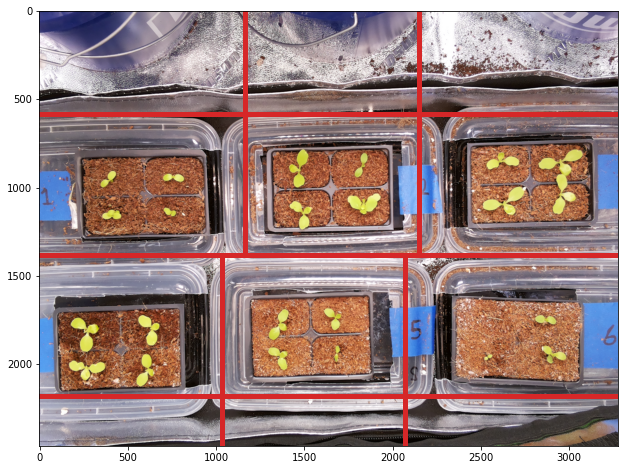

In [307]:
plt.figure(figsize=(15,8))
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgRGB, cmap='gray')
plt.axhline(yDivider, color='#d62728', linewidth=5)
plt.axhline(yDivider-800, color='#d62728', linewidth=5)
plt.axhline(yDivider+800, color='#d62728', linewidth=5)
yDRatio = yDivider/dilatedFinal.shape[0]
plt.axvline(x1Top, 1, 1-yDRatio, color='#d62728', linewidth=5)
plt.axvline(x2Top, 1, 1-yDRatio, color='#d62728', linewidth=5)
plt.axvline(x1Bottom, 0, 1-yDRatio, color='#d62728', linewidth=5)
plt.axvline(x2Bottom, 0, 1-yDRatio, color='#d62728', linewidth=5)

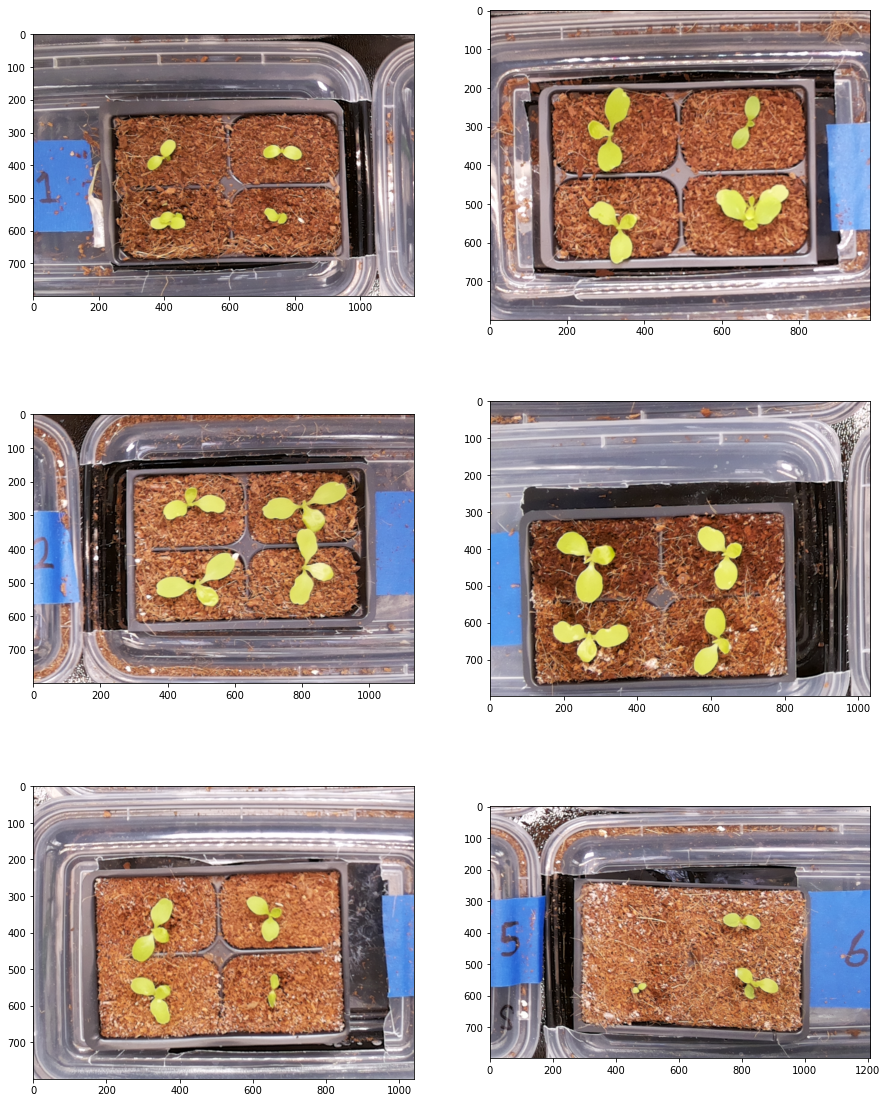

In [308]:
fig, ax = plt.subplots(3,2, figsize=(15,20))
y1 = int(yDivider) - 800
y2 = int(yDivider) 
y3 = int(yDivider) + 800
x1Top = int(x1Top)
x2Top = int(x2Top)
x1Bottom = int(x1Bottom)
x2Bottom = int(x2Bottom)


ax[0][0].imshow(imgRGB[y1:y2,0:x1Top])
ax[0][1].imshow(imgRGB[y1:y2,x1Top:x2Top])
ax[1][0].imshow(imgRGB[y1:y2,x2Top:])
ax[1][1].imshow(imgRGB[y2:y3,0:x1Bottom])
ax[2][0].imshow(imgRGB[y2:y3,x1Bottom:x2Bottom])
ax[2][1].imshow(imgRGB[y2:y3,x2Bottom:])

In [310]:
def find_x_critical_points(collapsedList, verbose=False):
    criticalPoints = [0]*6
    for i in range(len(collapsedList)):
        if collapsedList[i] > 0 and criticalPoints[0]==0:
            criticalPoints[0] = i
            if verbose: print(criticalPoints[0])
        if criticalPoints[0]!=0 and collapsedList[i] == 0 and criticalPoints[1]==0:
            criticalPoints[1] = i
            if verbose: print(criticalPoints[1])
        if criticalPoints[1]!=0 and collapsedList[i] != 0 and criticalPoints[2]==0:
            criticalPoints[2] = i
            if verbose: print(criticalPoints[2])
        if criticalPoints[2]!=0 and collapsedList[i] == 0 and criticalPoints[3]==0:
            criticalPoints[3] = i
            if verbose: print(criticalPoints[3])
        if criticalPoints[3]!=0 and collapsedList[i] != 0 and criticalPoints[4]==0:
            criticalPoints[4] = i
            if verbose: print(criticalPoints[4])
        if criticalPoints[4]!=0 and collapsedList[i] == 0 and criticalPoints[5]==0:
            criticalPoints[5] = i
            if verbose: print(criticalPoints[5])
    x1 = np.mean([criticalPoints[1], criticalPoints[2]])
    x2 = np.mean([criticalPoints[3], criticalPoints[4]])
    return criticalPoints, x1, x2

def separate_seed_trays_step2(imageTray):
    xCollapsed = np.mean(imageTray, axis=1)
    yDivider = np.mean(np.where(xCollapsed!=0))
    imageTrayTop = imageTray[0:int(yDivider), :]
    yCollapsedTop = np.mean(imageTrayTop, axis=0)
    criticalPoints, x1Top, x2Top = find_x_critical_points(yCollapsedTop)
    imageTrayBottom = imageTray[int(yDivider):, :]
    criticalPoints, x1Bottom, x2Bottom = find_x_critical_points(yCollapsedBottom)
    y1 = int(yDivider) - 800
    y2 = int(yDivider) 
    y3 = int(yDivider) + 800
    x1Top = int(x1Top)
    x2Top = int(x2Top)
    x1Bottom = int(x1Bottom)
    x2Bottom = int(x2Bottom)
    return (y1, y2, y3, x1Top, x2Top, x1Bottom, x2Bottom)

In [312]:
imageDirectory = "/media/jee/Shared Partition/camera/pre-move/day"
imageList = st.get_image_list(imageDirectory)
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    image = cv2.imread(file)
    imageTray = separate_seed_trays_step1(file)
    y1, y2, y3, x1Top, x2Top, x1Bottom, x2Bottom = separate_seed_trays_step2(imageTray)
    
    cv2.imwrite(file.replace('day','algo/1'), image[y1:y2,0:x1Top])
    cv2.imwrite(file.replace('day','algo/2'), image[y1:y2,x1Top:x2Top])
    cv2.imwrite(file.replace('day','algo/3'), image[y1:y2,x2Top:])
    cv2.imwrite(file.replace('day','algo/4'), image[y2:y3,0:x1Bottom])
    cv2.imwrite(file.replace('day','algo/5'), image[y2:y3,x1Bottom:x2Bottom])
    cv2.imwrite(file.replace('day','algo/6'), image[y2:y3,x2Bottom:])


In [313]:
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/1/", "timelapse", 20)
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/2/", "timelapse", 20)
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/3/", "timelapse", 20)
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/4/", "timelapse", 20)
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/5/", "timelapse", 20)
# st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/algo/6/", "timelapse", 20)

In [ ]:
x-special/nautilus-clipboard
copy
file:///media/jee/Shared%20Partition/camera/lettuce1-bad-pH
